In [23]:
!pip install torch torchvision torchaudio
!pip install torchsummary

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from google.colab import drive
import matplotlib.pyplot as plt
import random
from torchsummary import summary
# drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


!git --version



cuda
git version 2.34.1


In [24]:
# !git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git

In [25]:
WORKING_DIRECTORY = '/kaggle/working/'




In [26]:
dataset_path = "/kaggle/working/Face-Mask-Detection/dataset"

model_path = f"{WORKING_DIRECTORY}"

Classes: ['with_mask', 'without_mask']
Number of images: 4094
Number of classes: 2
Number of training images: 3275
Number of validation images: 819


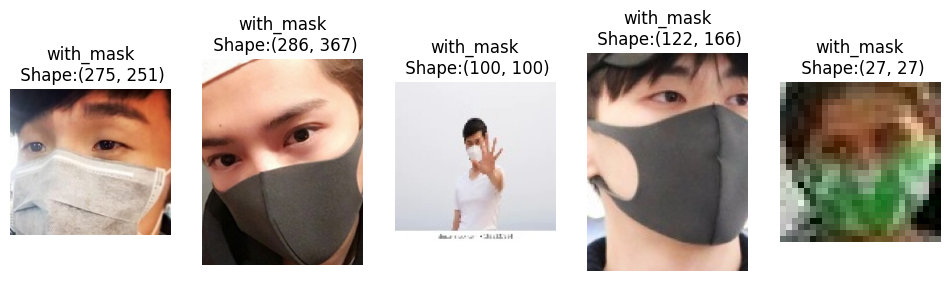

In [27]:

def load_dataset(dataset_path,split_ratio=0.80,batch_size=32):

  train_transform = transforms.Compose([
      transforms.Resize((128, 128)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
  ])


  val_transform = transforms.Compose([
      transforms.Resize((128, 128)),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
  ])

  #creating the  dataset
  dataset = ImageFolder(root=dataset_path)
  # Get class names
  class_names = dataset.classes
  print("Classes:", class_names)
  print("Number of images:", len(dataset))
  print("Number of classes:", len(class_names))


  fig, axes = plt.subplots(1, 5, figsize=(12, 4))  # Display 5 images

  for i in range(5):
      idx = random.randint(0, len(dataset) - 1)  # Random index
      image, label = dataset[idx]  # Load image and label
      axes[i].imshow(image)  # Display PIL image
      axes[i].set_title(f"{class_names[label]}\n Shape:{image.size}")  # Show class name
      axes[i].axis("off")



  train_size = int(split_ratio * len(dataset))

  #creating traning and validation dataset
  val_size = len(dataset) - train_size
  train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

  train_data.dataset.transform = train_transform
  val_data.dataset.transform = val_transform

  print("Number of training images:", len(train_data))
  print("Number of validation images:", len(val_data))




  # Create DataLoaders
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader


train_loader,val_loader = load_dataset(dataset_path)




In [28]:
import torch.nn as nn
import torch.nn.functional as F

# Define CNN Model
class MaskCNN(nn.Module):
    def __init__(self):
        super(MaskCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x



def training(num_epochs,learning_rate,model,loss_function,optimizer,model_weights_path=None,start_epoch=0,model_name="mask_cnn_3_layer"):

  if model_weights_path is not None:
    model.load_state_dict(torch.load(model_weights_path))

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = optimizer(model.parameters(), lr=learning_rate)
  for epoch in range(start_epoch, num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device).float().view(-1, 1)

          optimizer.zero_grad()
          outputs = model(images)
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          predictions = (outputs > 0.5).float()
          correct_train += (predictions == labels).sum().item()
          total_train += labels.size(0)

      train_loss = running_loss / len(train_loader)
      train_acc = correct_train / total_train
      train_losses.append(train_loss)
      train_accuracies.append(train_acc)

      # Validation
      model.eval()
      correct_val = 0
      total_val = 0
      running_val_loss = 0.0


      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device).float().view(-1, 1)
              outputs = model(images)
              loss = loss_function(outputs, labels)
              running_val_loss += loss.item()

              predictions = (outputs > 0.5).float()
              correct_val += (predictions == labels).sum().item()
              total_val += labels.size(0)

      val_loss = running_val_loss / len(val_loader)
      val_acc = correct_val / total_val
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)
      torch.save(model.state_dict(), f"{model_path}/{model_name}_epoch_{epoch+1}.pth")
      print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  return model, train_losses, val_losses, train_accuracies, val_accuracies







In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies):
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', marker='o')
  plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='s')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training vs Validation Accuracy")
  plt.legend()
  plt.grid()
  plt.show()




In [30]:
def compute_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mask", "No Mask"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Loss: 0.7770, Train Acc: 0.5478, Val Loss: 0.6756, Val Acc: 0.5275


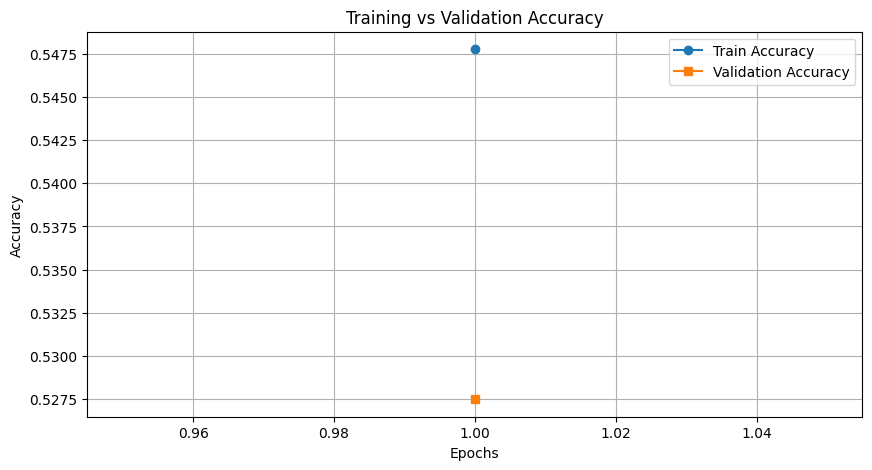

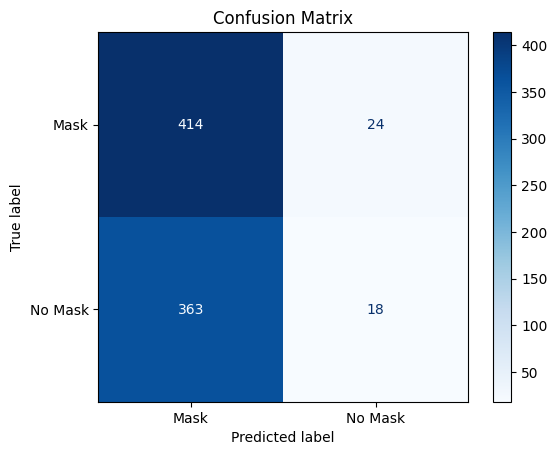

In [32]:
lr = 0.01
num_epochs = 1
model = MaskCNN()
# summary(model, (3, 128, 128))
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=None,start_epoch=0,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)


<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 2: Train Loss: 0.7005, Train Acc: 0.5316, Val Loss: 0.6915, Val Acc: 0.5348


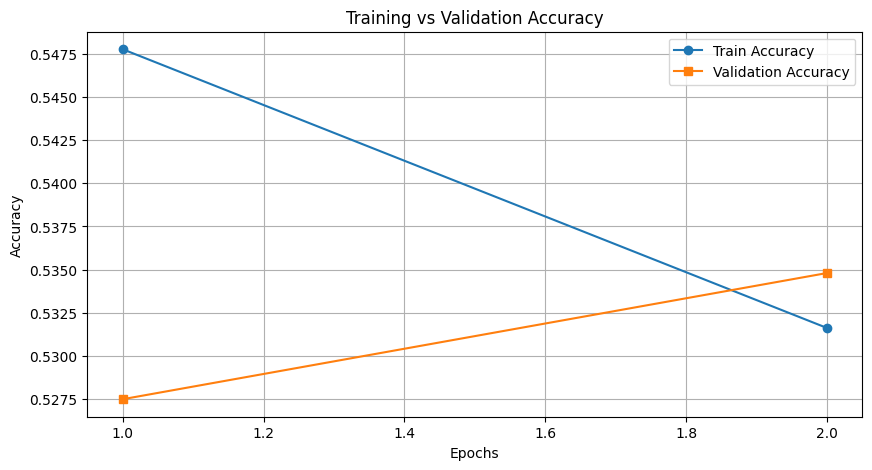

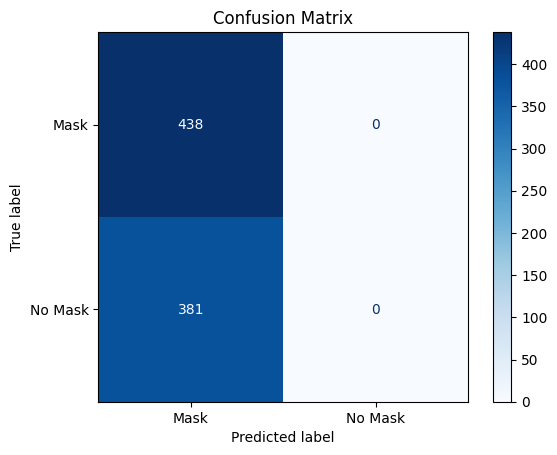

In [33]:
num_epochs = 2
start_epoch=1
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 3: Train Loss: 0.6475, Train Acc: 0.6012, Val Loss: 0.5573, Val Acc: 0.7460


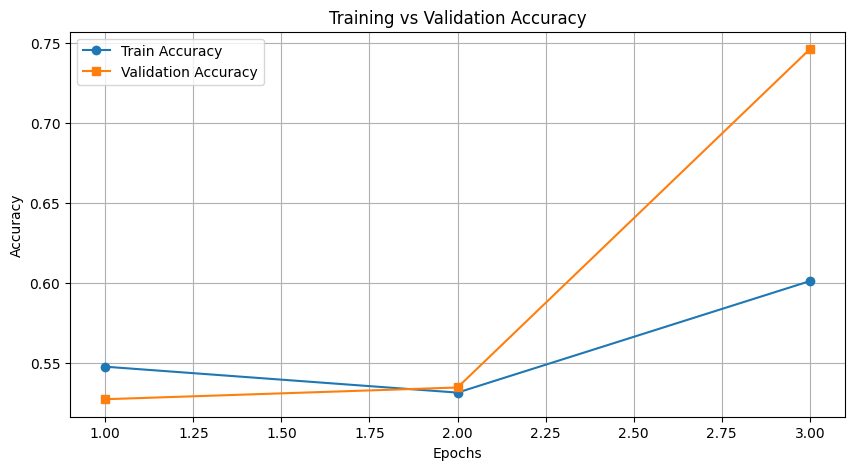

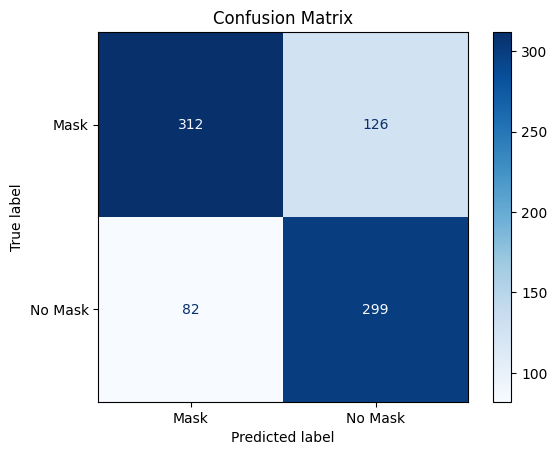

In [34]:
num_epochs = 3
start_epoch=2
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 4: Train Loss: 0.6122, Train Acc: 0.6913, Val Loss: 0.4885, Val Acc: 0.7705


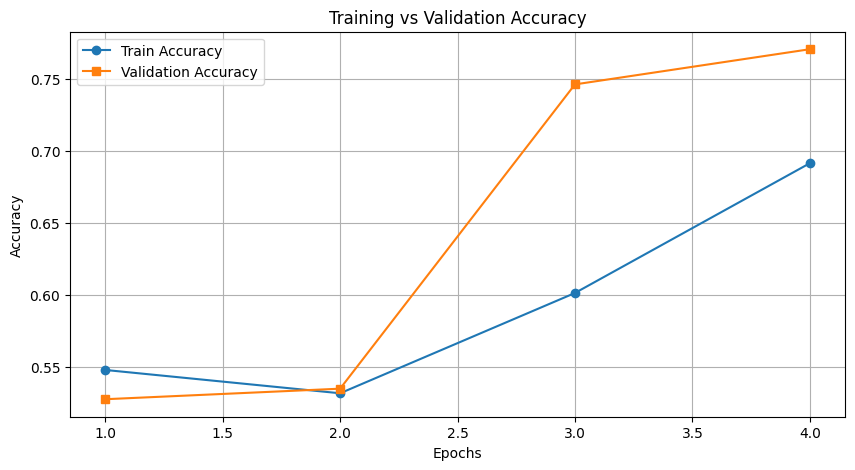

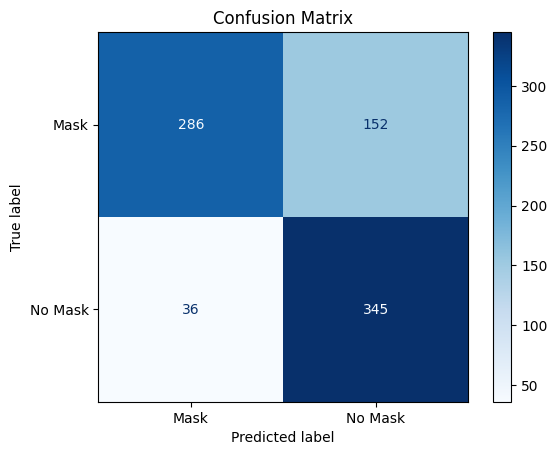

In [35]:
num_epochs = 4
start_epoch=3
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 5: Train Loss: 0.4672, Train Acc: 0.7936, Val Loss: 0.3668, Val Acc: 0.8486


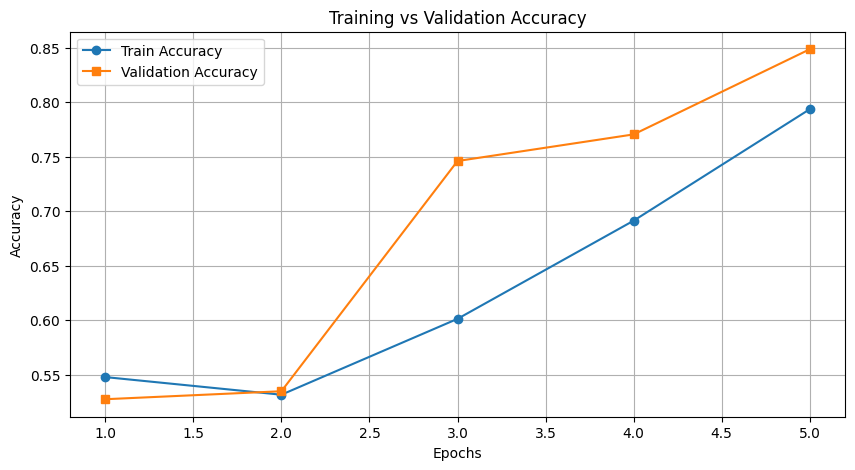

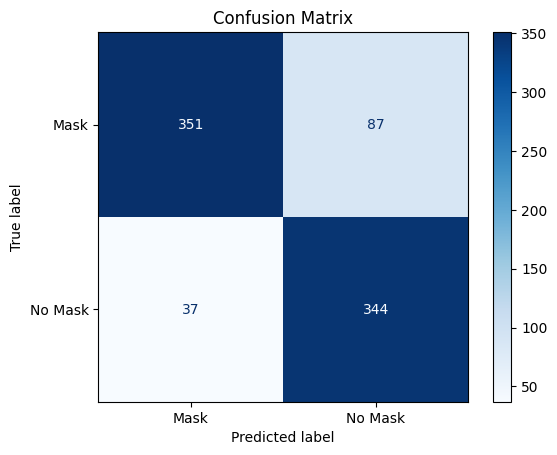

In [36]:
num_epochs = 5
start_epoch=4
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 6: Train Loss: 0.4158, Train Acc: 0.8308, Val Loss: 0.3628, Val Acc: 0.8388


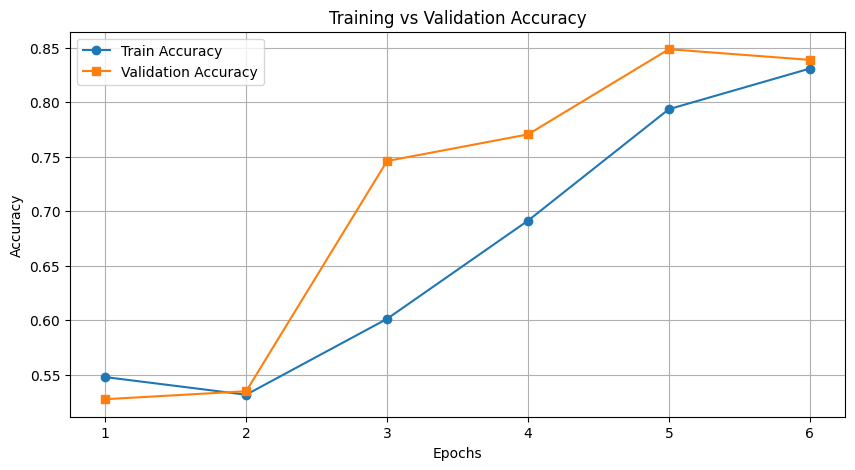

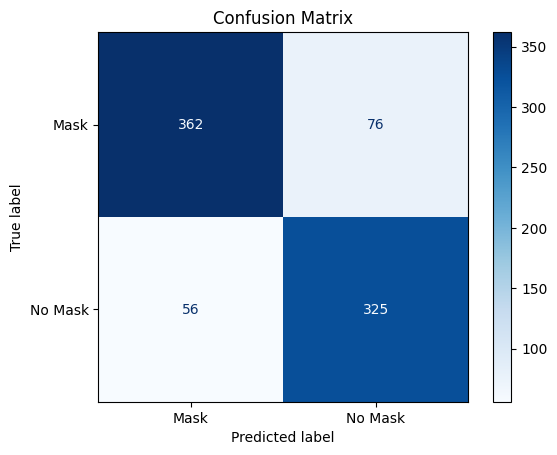

In [37]:
num_epochs = 6
start_epoch=5
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 7: Train Loss: 0.3509, Train Acc: 0.8650, Val Loss: 0.2584, Val Acc: 0.8913


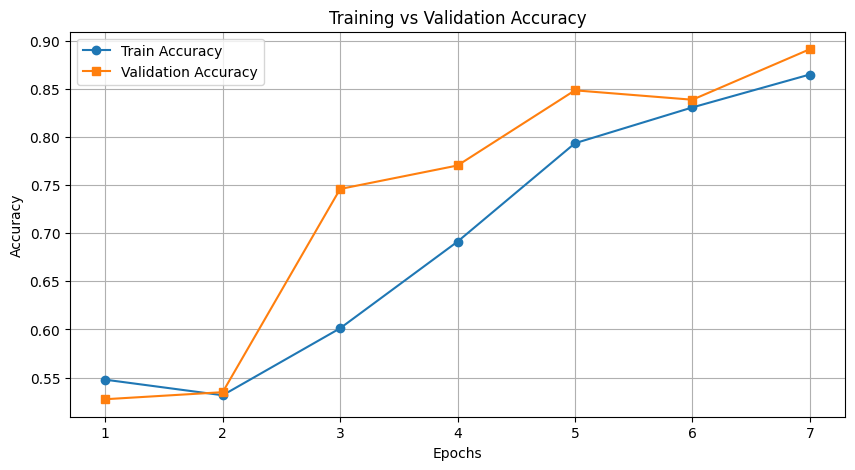

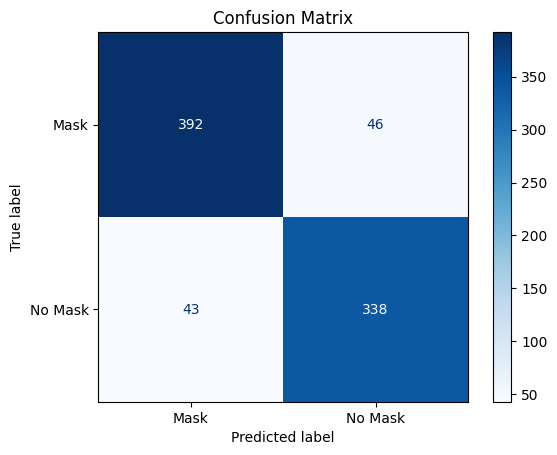

In [38]:
num_epochs = 7
start_epoch=6
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 8: Train Loss: 0.3015, Train Acc: 0.8846, Val Loss: 0.3090, Val Acc: 0.8694


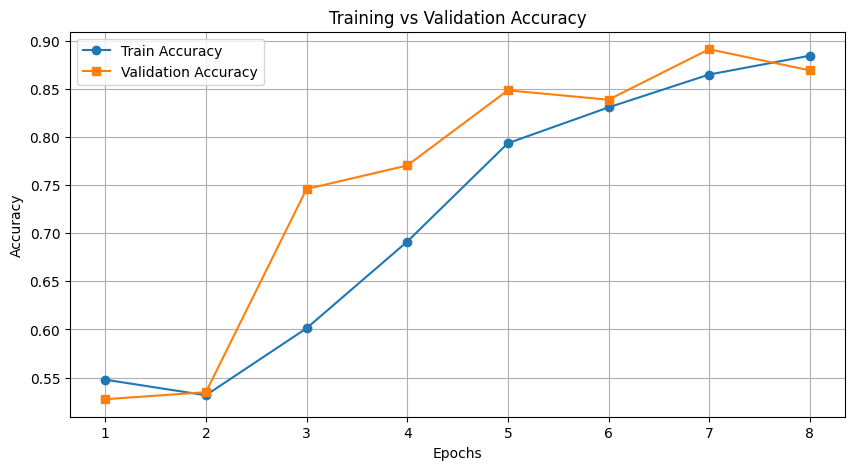

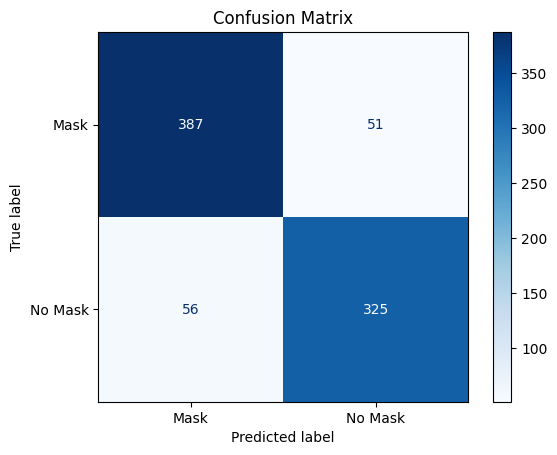

In [39]:
num_epochs = 8
start_epoch=7
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 9: Train Loss: 0.2743, Train Acc: 0.8983, Val Loss: 0.2493, Val Acc: 0.8962


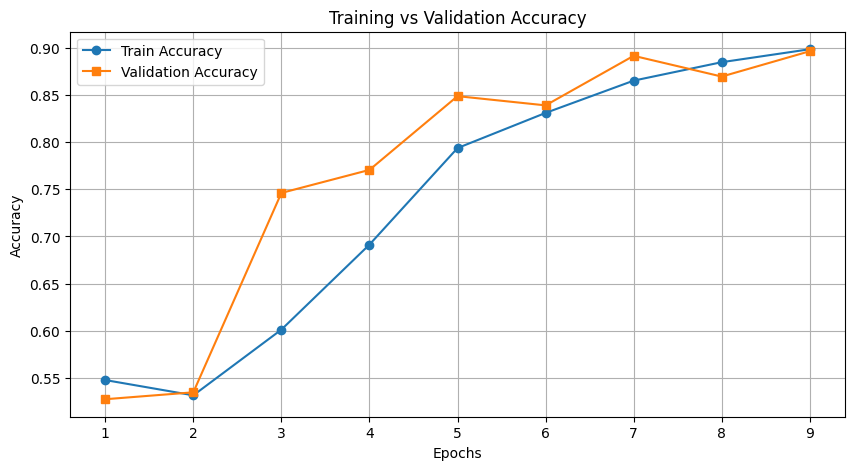

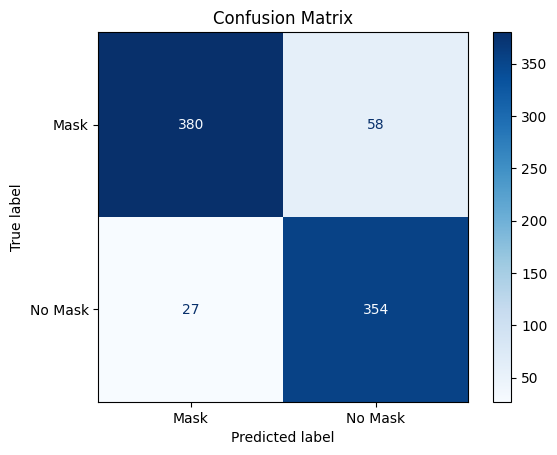

In [40]:
num_epochs = 9
start_epoch=8
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 10: Train Loss: 0.2793, Train Acc: 0.9005, Val Loss: 0.2842, Val Acc: 0.8852


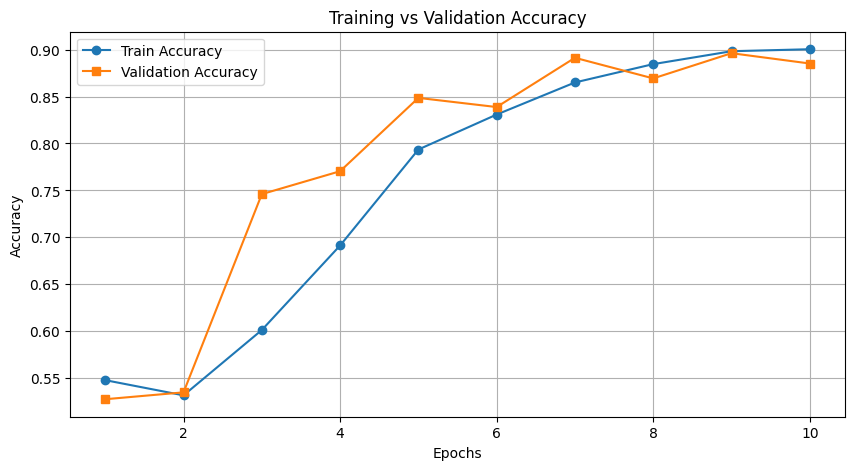

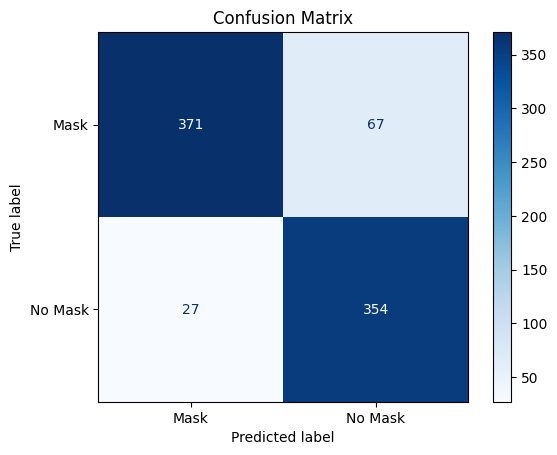

In [41]:
num_epochs = 10
start_epoch=9
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)

<ipython-input-28-3dace1953cbb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))
/usr/local/lib/python3.10/dist-packag

Epoch 11: Train Loss: 0.2771, Train Acc: 0.8962, Val Loss: 0.2662, Val Acc: 0.8889


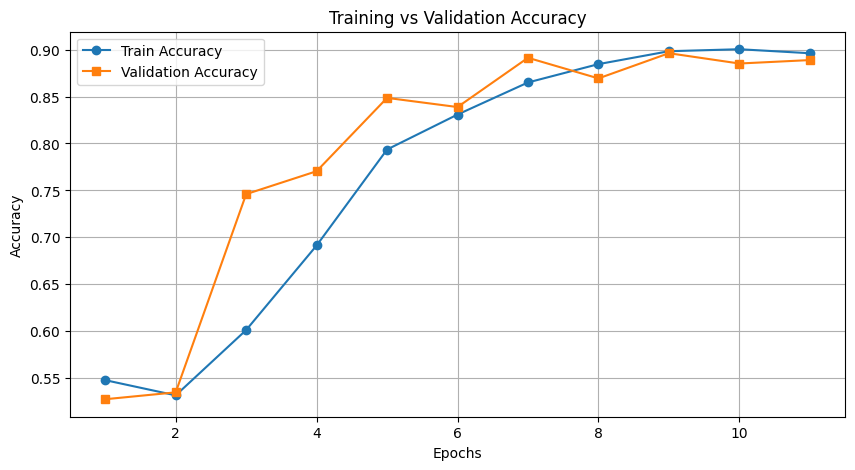

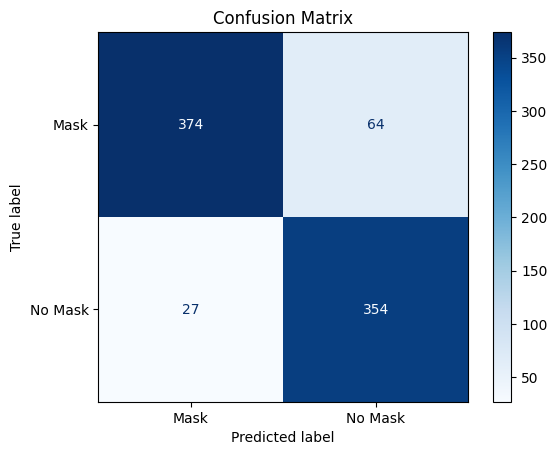

In [42]:
num_epochs = 11
start_epoch=10
model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs,lr,model,loss_function,optimizer,model_weights_path=f"{model_path}/mask_cnn_3_layer_epoch_{start_epoch}.pth",start_epoch=start_epoch,model_name="mask_cnn_3_layer")
train_accuracies.extend(train_accuracy)
val_accuracies.extend(val_accuracy)
train_losses.extend(train_loss)
val_losses.extend(val_loss)
plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
compute_confusion_matrix(model, val_loader)